# Evaluating Tikhonet Trained

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [ ]:
%matplotlib inline
import sys

# Directories and paths
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_cfht/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import galflow as gf
from galaxy2galaxy import problems
import pickle

# set random seed
tf.random.set_random_seed(2)

# Functions

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance, laplacian=True):
    r"""Applies Wiener filter to image.

    This function takes an image in the direct space and its corresponding PSF in the
    Fourier space and performs a deconvolution using the Wiener Filter.

    Parameters
    ----------
    image   : 2D TensorFlow tensor
        Image in the direct space.
    psf     : 2D TensorFlow tensor
        PSF in the Fourier space (or K space).
    balance : scalar
        Weight applied to regularization.
    laplacian : boolean
        If true the Laplacian regularization is used else the identity regularization 
        is used.

    Returns
    -------
    tuple
        The first element is the filtered image in the Fourier space.
        The second element is the PSF in the Fourier space (also know as the Transfer
        Function).
    """
    trans_func = psf
    if laplacian:
        reg = laplacian_tf(image.shape)
        if psf.shape != reg.shape:
            trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
        else:
            trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance
    if laplacian:
        arg3 *= tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    # Apply wiener in Foutier (or K) space
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.

    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # First, we add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    sigma_cfht = 23.59
    dico['inputs_noiseless'] = tf.identity(dico['inputs'])
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    # Normalize the Unet inputs to improve the training
    norm_factor = 4e3
    dico['inputs'] = dico['inputs']/norm_factor
    dico['targets'] = dico['targets']/norm_factor

    # Second, we interpolate the image on a finer grid
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx = 64
    Ny = 64
    dico['inputs_cfht'] = tf.image.resize(dico['inputs'],
                    [Nx*interp_factor,
                    Ny*interp_factor],
                    method=x_interpolant)
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs_cfht'] = dico['inputs_cfht'] / interp_factor**2

    balance = 9e-3  # determined using line search
    dico['inputs_tikho'], _ = wiener_tf(dico['inputs_cfht'][...,0], dico['psf_cfht'][...,0], balance)
    dico['inputs_tikho'] = tf.expand_dims(dico['inputs_tikho'], axis=0)
    psf_hst = tf.reshape(dico['psf_hst'], [dico['psf_hst'].shape[-1],*dico['psf_hst'].shape[:2]])
    psf_hst = tf.cast(psf_hst, 'complex64')
    # gf.kconvolve performs a convolution in the K (Fourier) space
    # inputs are given in K space
    # the output is in the direct space
    dico['inputs_tikho'] = gf.kconvolve(dico['inputs_tikho'], psf_hst,zero_padding_factor=1,interp_factor=interp_factor)

    return dico

## Generate The Evaluation Dataset

In [ ]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
dset = problem128.dataset(Modes.EVAL, data_dir=data_path+'attrs2img_cosmos_cfht2hst/')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)

n_batch = 128

dset = dset.batch(n_batch)

## Extract Batches and Concatenate Them

In [ ]:
# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()
sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)
k_batch = 24 #16

for k in range(k_batch-1):
    # Extract temporary batch
    tmp = sess.run(iterator)
    # Add to batch
    for key in tmp:
        batch[key]=np.concatenate((batch[key],tmp[key]))
sess.close()

## Load and Apply Trained Model on Batch

In [4]:
for key in ['inputs', 'psf_hst', 'targets', 'psf_cfht', 'inputs_cfht', 'inputs_tikho']:
    batch[key] = batch[key][...,0]

# generate the psfs in the spatial domain
shape = batch['inputs'].shape[1:]
psf_hst = np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0], s=shape))
psf_tile_cfht = np.array([np.fft.ifftshift(np.fft.irfft2(p, s=shape)) for p in batch['psf_cfht']])
# make psf tiles
psf_tile_hst = np.repeat(psf_hst[np.newaxis, :, :], k_batch*n_batch, axis=0)
# psf_tile_cfht = np.repeat(psf_cfht[np.newaxis, :, :], k_batch*n_batch, axis=0)

## Plot Galaxy Images

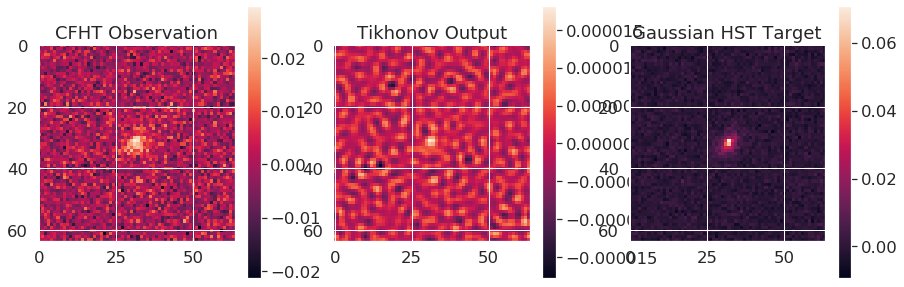

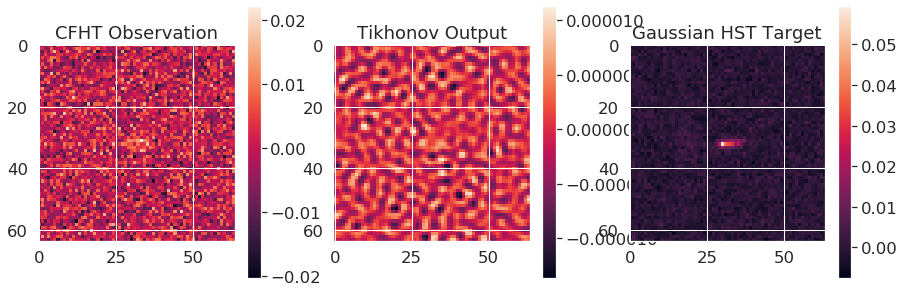

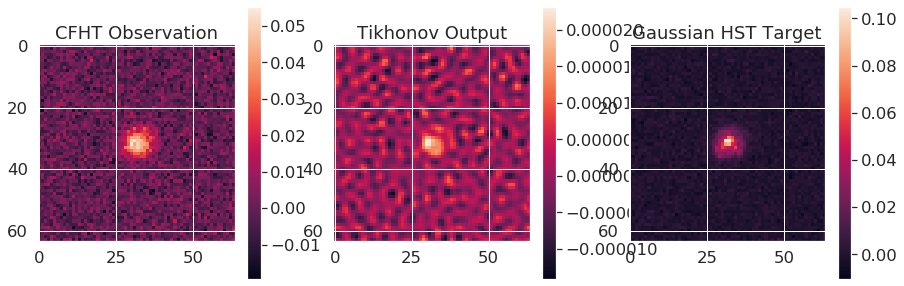

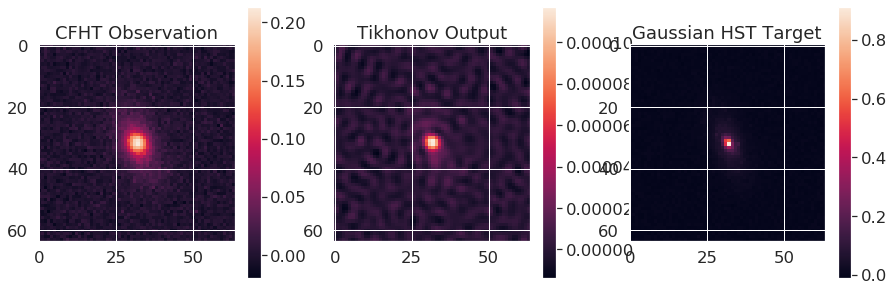

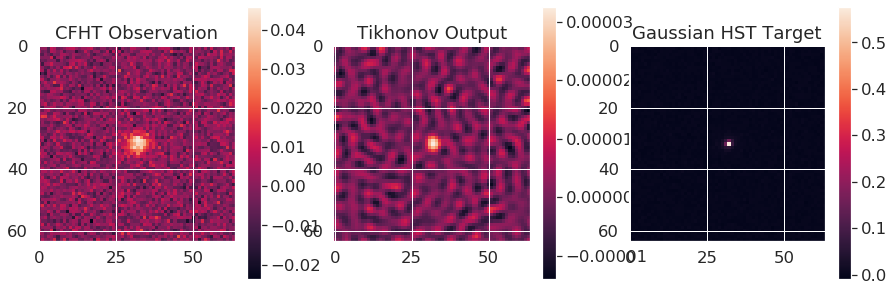

In [5]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(5):#n_batch):
    plt.figure(33,figsize=(15,5))
    plt.subplot(131)
    plt.imshow(batch['inputs'][i])
    plt.title('CFHT Observation')
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(batch['inputs_tikho'][i])
    plt.title('Tikhonov Output')
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(batch['targets'][i])
    plt.title('Gaussian HST Target')
    plt.colorbar()
    plt.show()

## Processing and Analyzing Results

### Define Error Metrics

In [6]:
U = cl.makeUi(*batch['inputs_tikho'].shape[1:3])
im_size = 64
scale = 0.1

def estimate_ell(img):
    GX = np.array([cl.scal(img,U_i) for U_i in U])
    mu20 = 0.5*(GX[3]+GX[4])-GX[0]**2/GX[2]
    mu02 = 0.5*(GX[3]-GX[4])-GX[1]**2/GX[2]
    mu11 = GX[5]-GX[0]*GX[1]/GX[2]
    e1 = (mu20-mu02)/(mu20+mu02)
    e2 = 2*(mu11)/(mu20+mu02)
    e = np.array([e1,e2])
    return e

def EllipticalGaussian(e1, e2, sig, xc=im_size//2, yc=im_size//2, stamp_size=(im_size,im_size)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

def relative_mse(solution, ground_truth):
    relative_mse = ((solution-ground_truth)**2).mean()/ \
                         (ground_truth**2).mean()
    return relative_mse



def get_KSB_ell(image,psf):
    error_flag = True
    #create a galsim version of the data
    image_galsim = Image(image,scale=scale)
    psf_galsim = Image(psf,scale=scale)
    #estimate the moments of the observation image
    ell=galsim.hsm.EstimateShear(image_galsim
                                 ,psf_galsim,shear_est='KSB'
                                 ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                 ,strict=False)
    if ell.error_message != '':
        error_flag = False
    return ell#,error_flag

def get_KSB_g(images,psfs):
    g_list,error_flag_list=[],[]
    for image,psf in zip(images,psfs):
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        # CHECK ADAPTIVE MOMENTS
        psf_galsim = galsim.Image(psf,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.EstimateShear(image_galsim
                                         ,psf_galsim,shear_est='KSB'
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        g = np.array([shape.corrected_g1, shape.corrected_g2])
#        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
    return np.array(g_list).T,np.array(error_flag_list)

def get_moments(images, bool_window=False):
    g_list,error_flag_list=[],[]
    if bool_window:
        window_list = []
        window_flag_list = []
    for image in images:
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.FindAdaptiveMom(image_galsim
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        if bool_window:
            k_sigma = 3 #scale up the size of the Gaussian window to make it able to capture more useful signal
            window = EllipticalGaussian(-1.*shape.observed_shape.e1, shape.observed_shape.e2 #convention fix:
                                                                                             #e1 sign swap
                                 ,shape.moments_sigma*k_sigma # convention fix: swap x and y and origin at (0,0)
                                 ,shape.moments_centroid.y-1, shape.moments_centroid.x-1
                                 ,image.shape)
            window_flag = bool(shape.moments_status+1)
        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
        if bool_window:
            window_list += [window]
            window_flag_list += [window_flag]
    output = [np.array(g_list).T,np.array(error_flag_list)]
    if bool_window:
        output += [np.array([window_list])[0],np.array([window_flag_list])[0]]
    return output

def g_to_e(g1,g2):
    shear = galsim.Shear(g1=g1,g2=g2)
    ell = -shear.e1, shear.e2 #reverse the signe of e_1 to get our conventions
    return ell

def MSE(X1,X2,norm=False):
    #Computes the relative MSE
    temp = 1
    if norm:
        temp = np.mean(X2**2)
    return np.mean((X1-X2)**2)/temp

def MSE_obj(obj1,obj2,norm=False):
    return np.array([MSE(o1,o2,norm) for o1,o2 in zip(obj1,obj2)])

### Estimate Unwindowed Ellipticities, KSB shear and Adaptive Moments

In [7]:
ell_hst = np.array([estimate_ell(gal) for gal in batch['targets']]).T

mom_hst,flags_hst,windows, window_flags = get_moments(batch['targets'],bool_window=True)

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [8]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.34342447916666663


### Show Plot Images

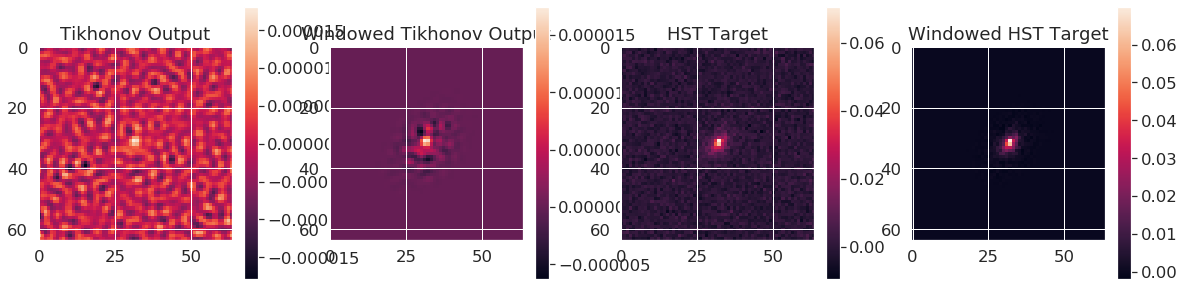

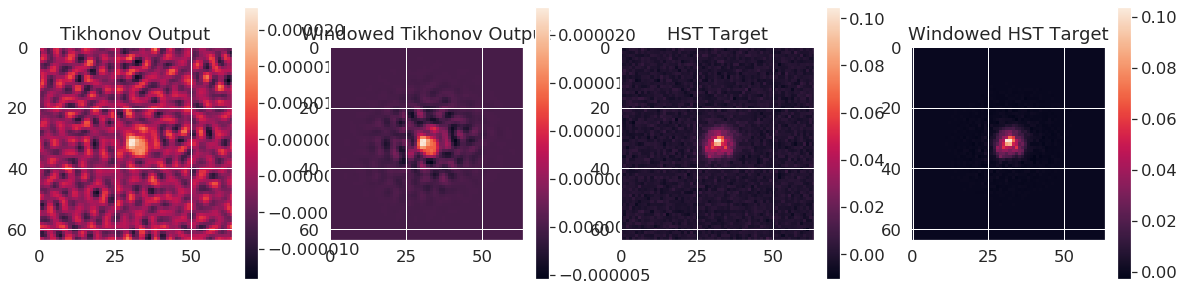

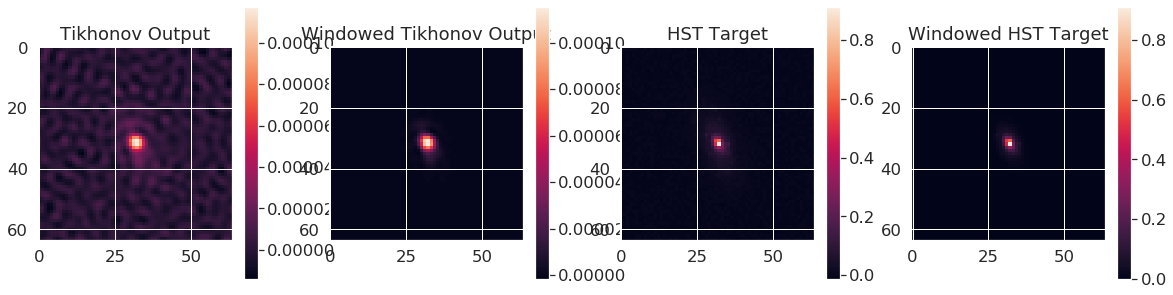

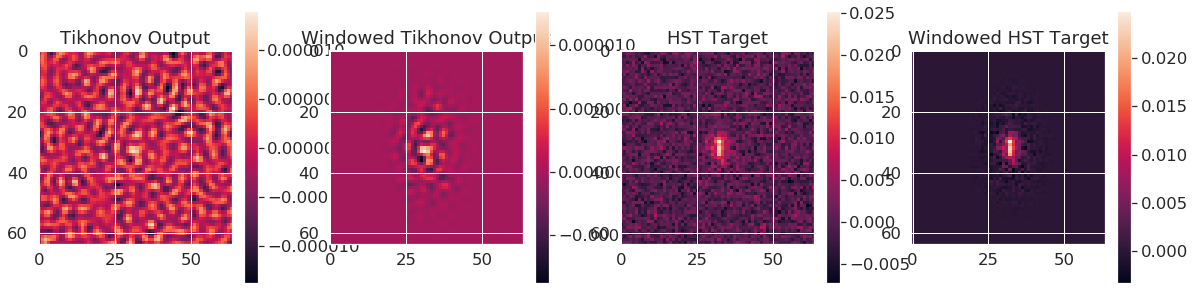

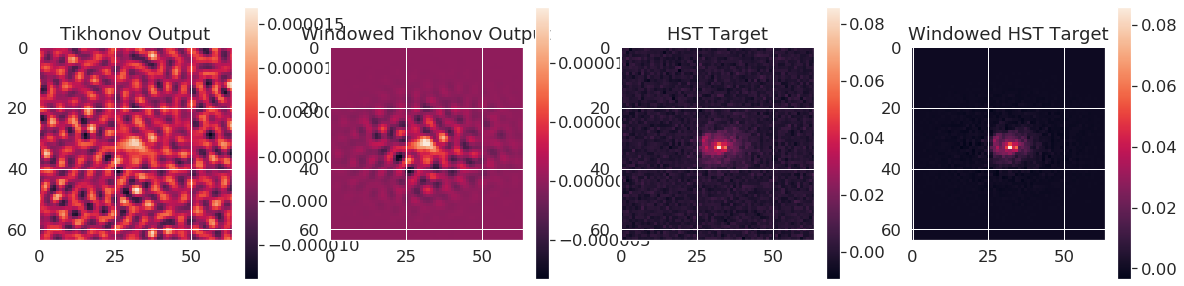

In [9]:
for i in range(5):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['inputs_tikho'][window_flags][i])
    plt.title('Tikhonov Output')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(batch['inputs_tikho'][window_flags][i]*windows[window_flags][i])
    plt.title('Windowed Tikhonov Output')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(batch['targets'][window_flags][i])
    plt.title('HST Target')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['targets'][window_flags][i]*windows[window_flags][i])
    plt.title('Windowed HST Target')
    plt.colorbar()
    plt.show()

## Add Entries to Batch

In [10]:
batch['windows'] = windows
batch['windows_flag'] = window_flags
batch['targets_mom'] = mom_hst
batch['target_ell'] = ell_hst

## Save Batch

In [11]:
f = open(data_path+"cfht_batch.pkl","wb")
pickle.dump(batch,f)
f.close()

## Check Saved Batch

In [12]:
f = open(data_path+"cfht_batch.pkl", "rb")
favorite_color = pickle.load(f)
f.close()

In [13]:
for key in favorite_color:
    print(key)
    print((favorite_color[key] == batch[key]).all())

flux_radius
True
inputs
True
mag_auto
True
ps_cfht
True
ps_hst
True
psf_cfht
True
psf_hst
True
targets
True
attributes
True
inputs_noiseless
True
inputs_cfht
True
inputs_tikho
True
windows
True
windows_flag
True
targets_mom
True
target_ell
True
